In [58]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, GaussianNoise, Flatten, Activation, Dropout, RepeatVector, Permute, Lambda, concatenate, dot, multiply
from tensorflow.keras.models import Model
from keras.layers import TimeDistributed
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

def normalize(data):
  min = np.min(data,axis = 0)
  max = np.max(data,axis = 0)
  #print('min, max',min, max)
  data =  (data-min)/(max-min)
  return data
# Generate sample data
def generate_data(n_points, n_features, window_size):
    data = np.random.randn(n_points, n_features)
    data = normalize(data)
    #data = np.random.normal(loc= 0.0, scale= 1.0 ,size = (n_points, n_features))
    X = []
    Y = []
    #print(data)
    for i in range(0, n_points-2*window_size+1):
      X.append(data[i:i+window_size,:])
      Y.append(data[i+window_size:i+2*window_size,:])
    return X, Y
# Parameters
n_points = 200
n_features = 3
window_size = 8
n_train = int((n_points-2*window_size)*0.9)  #80% training samples

In [59]:
#n_train = 30

In [60]:
# Generate data
X, Y = generate_data(n_points, n_features, window_size)
print(len(X), len(Y))

X_train, y_train = np.stack(X[:n_train]), np.stack(Y[:n_train])
X_test, y_test = np.stack(X[n_train:]), np.stack(Y[n_train:])
print(f'x_train: {X_train.shape}, y_train: {y_train.shape}, x_test: {X_test.shape}, y_train: {y_test.shape}')


185 185
x_train: (165, 8, 3), y_train: (165, 8, 3), x_test: (20, 8, 3), y_train: (20, 8, 3)


Epoch 1/2000
5/5 [==============================] - 6s 169ms/step - loss: 0.2592 - val_loss: 0.1666
Epoch 2/2000
5/5 [==============================] - 0s 24ms/step - loss: 0.1110 - val_loss: 0.0750
Epoch 3/2000
5/5 [==============================] - 0s 29ms/step - loss: 0.0501 - val_loss: 0.0413
Epoch 4/2000
5/5 [==============================] - 0s 26ms/step - loss: 0.0396 - val_loss: 0.0493
Epoch 5/2000
5/5 [==============================] - 0s 28ms/step - loss: 0.0426 - val_loss: 0.0423
Epoch 6/2000
5/5 [==============================] - 0s 24ms/step - loss: 0.0349 - val_loss: 0.0398
Epoch 7/2000
5/5 [==============================] - 0s 23ms/step - loss: 0.0339 - val_loss: 0.0420
Epoch 8/2000
5/5 [==============================] - 0s 23ms/step - loss: 0.0344 - val_loss: 0.0419
Epoch 9/2000
5/5 [==============================] - 0s 27ms/step - loss: 0.0334 - val_loss: 0.0402
Epoch 10/2000
5/5 [==============================] - 0s 24ms/step - loss: 0.0329 - val_loss: 0.0391
Epoch 11

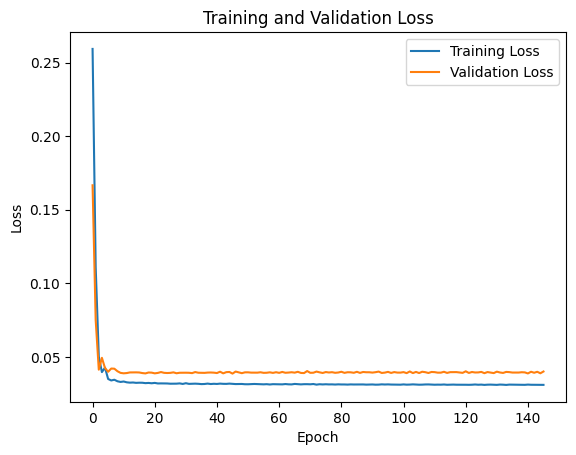

1/1 [==============================] - 0s 498ms/step
Test MAE: 0.15877832833163083
Test MSE: 0.037973730085666395
Test R-squared: -0.08093776753321565


In [61]:
# Define model
latent_dim = 32

dropout_rate = 0.4  # Example dropout rate

inputs = Input(shape=(None, n_features))
# First LSTM layer in the encoder with return_sequences=True
encoded = LSTM(latent_dim, activation='selu', return_sequences=True, go_backwards=True)(inputs)
encoded = Dropout(dropout_rate)(encoded)  # Adding dropout after the first LSTM layer
# Second LSTM layer in the encoder
encoded, state_h, state_c = LSTM(latent_dim, activation='selu', return_sequences=True, return_state=True)(encoded)
encoder_states = [state_h, state_c]

# Compute importance for each step
attention = Dense(1, activation='tanh')(encoded)
attention = Flatten()(attention)
attention = Activation('softmax', name='attention')(attention)
attention = RepeatVector(latent_dim)(attention)
attention = Permute([2, 1])(attention)

encoded = multiply([encoded, attention])
context = Lambda(lambda xin: tf.keras.backend.sum(xin, axis=1))(encoded)

# Decoder
decoder_input = Lambda(lambda x: tf.keras.backend.repeat(x[0], tf.shape(x[1])[1]))([context, inputs])
# First LSTM layer in the decoder with return_sequences=True
decoded = LSTM(latent_dim, activation='selu', return_state=False, return_sequences=True)(decoder_input, initial_state=encoder_states)
#decoded = Dropout(dropout_rate)(decoded)  # Adding dropout after the first LSTM layer
# Second LSTM layer in the decoder
# decoded = LSTM(latent_dim, activation='selu', return_sequences=True)(decoded)

attention = dot([decoded, encoded], axes=[2, 2])
attention = Activation('softmax')(attention)
attention = dot([attention, encoded], axes=[2,1])
decoded = concatenate([attention, decoded])

decoded = TimeDistributed(Dense(n_features), name='autoencoder')(decoded)

# Define models
encoder = Model(inputs, context)
autoencoder = Model(inputs, decoded)

# Compile model
autoencoder.compile(optimizer="adam", loss="mse")

# Train model
es = EarlyStopping(monitor='val_loss', patience=100, verbose=0, restore_best_weights=True)
history = autoencoder.fit(X_train, y_train, epochs=2000, batch_size=32, verbose=1, validation_split=0.1, callbacks = [es])

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

y_pred = autoencoder.predict(X_test)
#print(y_pred.shape, y_pred)
yy_pred = y_pred.reshape(-1,3)
yy_test = y_test.reshape(-1,3)

mse = mean_squared_error(yy_test, yy_pred)
mae = mean_absolute_error(yy_test, yy_pred)
r2 = r2_score(yy_test, yy_pred)

print("Test MAE:", mae)
print("Test MSE:", mse)
print("Test R-squared:", r2)



In [62]:
autoencoder.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, None, 3)]            0         []                            
                                                                                                  
 lstm_21 (LSTM)              (None, None, 32)             4608      ['input_8[0][0]']             
                                                                                                  
 dropout_7 (Dropout)         (None, None, 32)             0         ['lstm_21[0][0]']             
                                                                                                  
 lstm_22 (LSTM)              [(None, None, 32),           8320      ['dropout_7[0][0]']           
                              (None, 32),                                                  

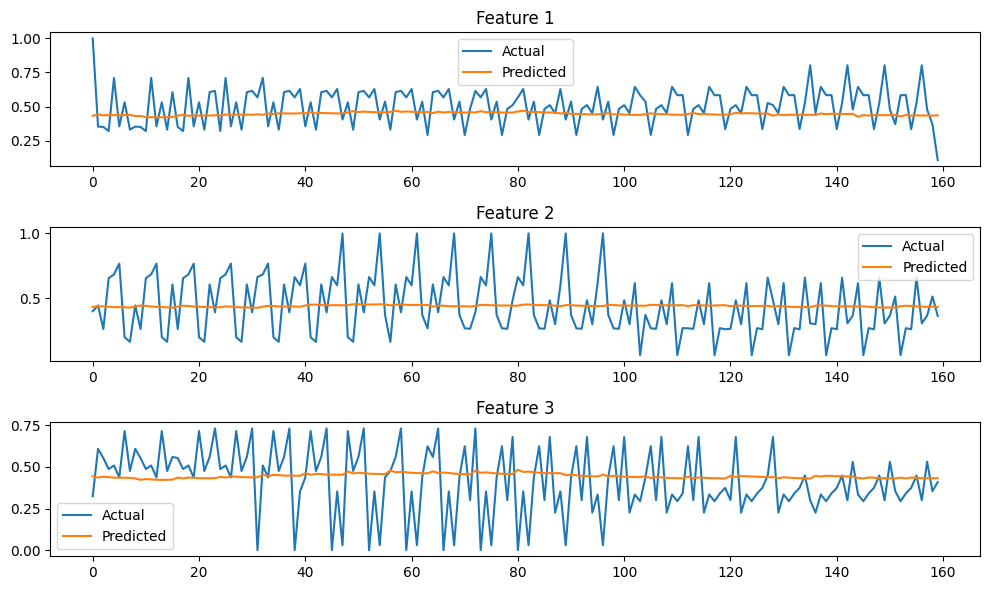

In [63]:
# Plotting
plt.figure(figsize=(10, 6))
for i in range(n_features):
    plt.subplot(n_features, 1, i+1)
    plt.plot(yy_test[:, i], label='Actual')
    plt.plot(yy_pred[:, i], label='Predicted')
    plt.title(f'Feature {i+1}')
    plt.legend()

plt.tight_layout()
plt.show()
plt.close()
